<a href="https://colab.research.google.com/github/sumadvena/SiOC_2023/blob/main/SiOC_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

Importowanie potrzebnych bibliotek i przygotowanie programu do działania

In [233]:
import os
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from skimage import color, io, measure
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import metrics, preprocessing, linear_model
from abc import abstractmethod
from typing import Optional
import pywt

## Tworzenie funkcji i interfejsu potrzebnego do zaaplikowania transformaty Fouriera i falkowej przy kompresji

###Obliczanie adaptacyjnego wskaźnika kompresji

In [234]:
def truncate_float(float_number, decimal_places):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

def adaptive_compression_ratio(coeffs):
    if(len(coeffs) % 2 != 0):
      del coeffs[-1] # the last one is not significant anyway

    thresh_difference = 0.0
    position = 0

    for i in range(len(coeffs)):
      if (i+1 < len(coeffs)):
        diff = coeffs[i+1] - coeffs[i]
        if (diff > thresh_difference):
          thresh_difference = diff
          position = i

    compression_ratio = (position / len(coeffs))
    return truncate_float(compression_ratio, 2)

In [235]:
class CompressionTransform:
    @abstractmethod
    def forward(self, variables: NDArray) -> NDArray:
        ...

    @abstractmethod
    def backward(self, variables: NDArray) -> NDArray:
        ...


class FourierTransform2D(CompressionTransform):
    def forward(self, variables: NDArray) -> NDArray:
        return np.fft.fft2(variables)

    def backward(self, variables: NDArray) -> NDArray:
        return np.abs(np.fft.ifft2(variables))


class WaveletTransform2D(CompressionTransform):
    def __init__(self, wavelet_name: str, level: int):
        self.wavelet_name = wavelet_name
        self.level = level
        self.slices: Optional[NDArray] = None

    def forward(self, variables: NDArray) -> NDArray:
        transformed = pywt.wavedec2(variables, self.wavelet_name, level=self.level)
        coefficients, slices = pywt.coeffs_to_array(transformed)
        self.slices = slices

        return coefficients

    def backward(self, variables: NDArray) -> NDArray:
        if self.slices is None:
            raise ValueError("Cannot perform inverse transform without first performing forward transform!")

        variables = pywt.array_to_coeffs(variables, self.slices, output_format="wavedec2")  # type: ignore
        return pywt.waverec2(variables, self.wavelet_name)


def compress_and_decompress(image: NDArray, transform: CompressionTransform, compression: float) -> NDArray:
    transformed = transform.forward(image)
    coefficients = np.sort(np.abs(transformed.reshape(-1)))  # sort by magnitude
    if (compression < 0):
      compression = adaptive_compression_ratio(coefficients)

    threshold = coefficients[int(compression * len(coefficients))]
    indices = np.abs(transformed) > threshold

    decompressed = transformed * indices
    return transform.backward(decompressed)

###Funkcja przy kompresji pozwalająca aplikować transformaty dla kolorowych obrazów

In [236]:
def apply_rgb(func: callable, image: NDArray, *args, **kwargs) -> NDArray:
    return np.dstack([func(image[:, :, channel], *args, **kwargs) for channel in range(3)])

##Obraz

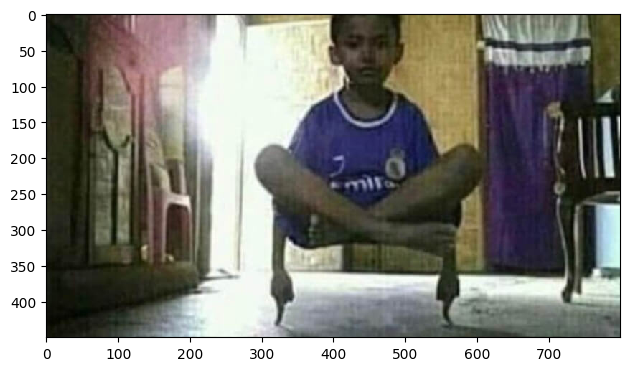

In [237]:
color_image = io.imread(r"/content/fimage.jpg")

io.imshow(color_image)

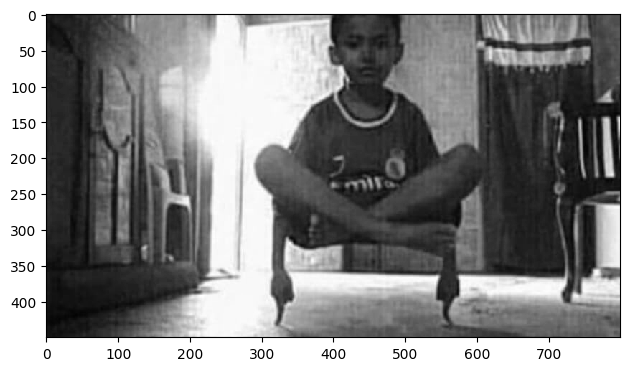

In [238]:
gray_image = color.rgb2gray(color_image)

io.imshow(gray_image)

#ODSZUMIANIE

##Odszumianie za pomocą gaussowskiego bluru
(dla porównania z odszumianiem za pomocą transformaty)

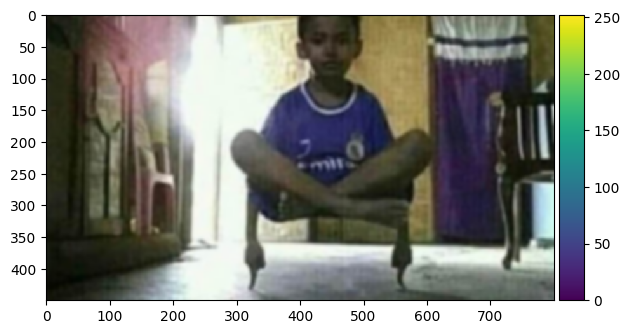

In [239]:
gauss_blur = np.dstack([
    ndimage.gaussian_filter(color_image[:, :, channel], 2)
    for channel in range(3)
])

_ = io.imshow(np.clip(gauss_blur.astype(int), 0, 255))

##Odszumianie za pomocą transformaty Fouriera

<ipython-input-240-a280213e74dd>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  _ = io.imshow(np.clip(fft_c_img.astype(int), 0, 255))


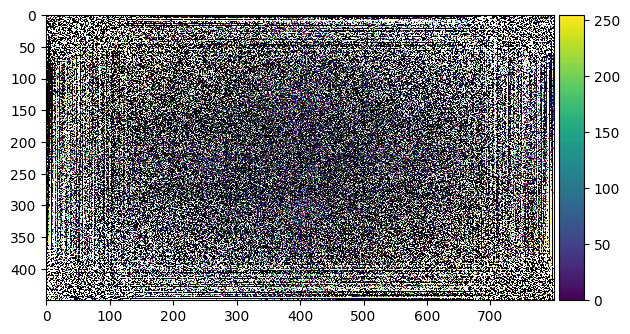

In [240]:
fft_c_img = np.dstack([
    np.fft.fft2(color_image[:, :, channel])
    for channel in range(3)
])

_ = io.imshow(np.clip(fft_c_img.astype(int), 0, 255))

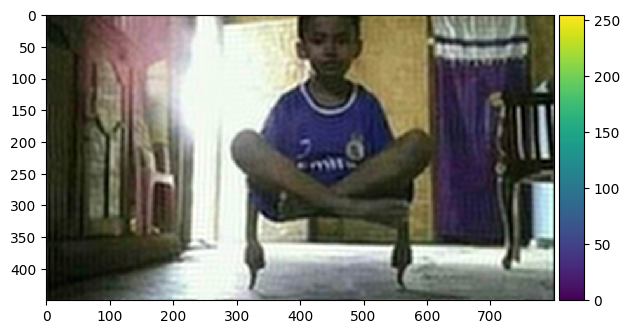

In [241]:
def filter_image(img, keep_fraction=0.1):
    img_fft = img.copy()
    r = img_fft.shape[0]
    c = img_fft.shape[1]
    img_fft[int(r*keep_fraction):int(r*(1-keep_fraction)), :] = 0
    img_fft[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
    filtered_img = np.real(np.fft.ifft2(img_fft))
    return filtered_img

denoised_c_img = np.dstack([
    filter_image(fft_c_img[:, :, channel])
    for channel in range(3)
])

io.imshow(np.clip(denoised_c_img.astype(int), 0, 255))

##Odszumianie szarego obrazu za pomocą transformacji falkowej

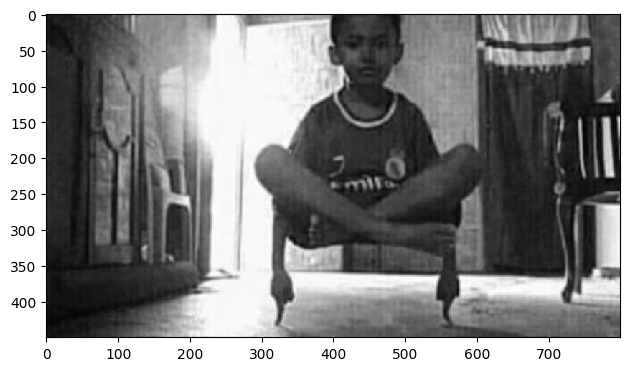

In [242]:
wavelet = pywt.Wavelet("haar")
levels = int(np.floor(np.log2(gray_image.shape[0])))

def denoise(image, wavelet, noise_sigma):
  wc = pywt.wavedec2(gray_image, wavelet, level=levels)
  arr, coeff_slices = pywt.coeffs_to_array(wc)
  arr = pywt.threshold(arr, noise_sigma, mode='soft')
  nwc = pywt.array_to_coeffs(arr, coeff_slices, output_format= 'wavedec2')
  return pywt.waverec2(nwc, wavelet)

img_denoised = denoise(gray_image, wavelet, 0.0001)

io.imshow(img_denoised)

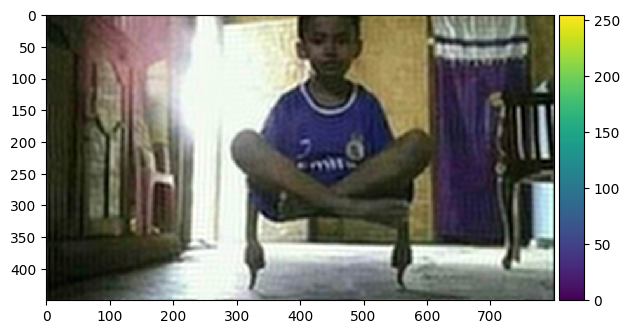

In [243]:
def filter_image(img, keep_fraction=0.1):
    img_fft = img.copy()
    r = img_fft.shape[0]
    c = img_fft.shape[1]
    img_fft[int(r*keep_fraction):int(r*(1-keep_fraction)), :] = 0
    img_fft[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
    filtered_img = np.real(np.fft.ifft2(img_fft))
    return filtered_img

denoised_c_img = np.dstack([
    filter_image(fft_c_img[:, :, channel])
    for channel in range(3)
])

io.imshow(np.clip(denoised_c_img.astype(int), 0, 255))

#KOMPRESJA

Aby użyć algorytmu, który sam dobierze rozmiar współczynnika kompresji, należy ustawić parametr **compression** poniżej zera.

##Za pomocą transformaty Fouriera dla obrazów kolorowych i szarych

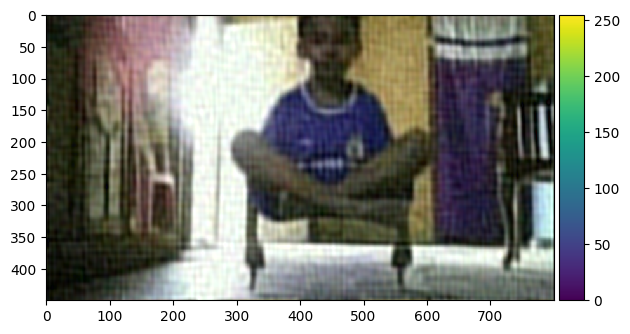

In [244]:
decompressed_image = apply_rgb(compress_and_decompress, color_image, transform=FourierTransform2D(), compression=-1)
_ = io.imshow(np.clip(decompressed_image.astype(int), 0, 255))

Przy kompresji powyżej 68% obraz zmienia barwy

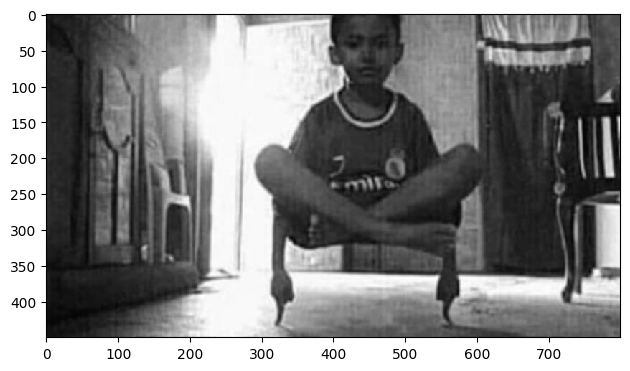

In [248]:
decompressed_image = compress_and_decompress(gray_image, transform=FourierTransform2D(), compression=0.68)
io.imshow(decompressed_image)

##Za pomocą transformaty falkowej

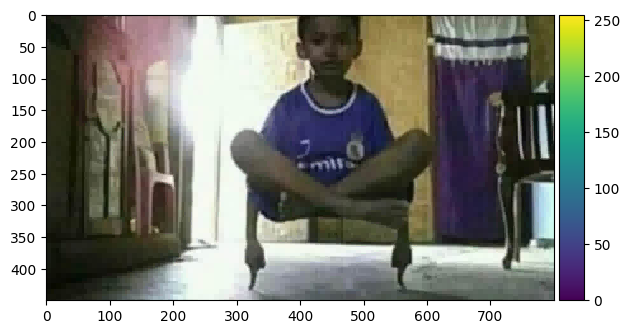

In [246]:
decompressed_image = apply_rgb(compress_and_decompress, color_image, transform=WaveletTransform2D(wavelet_name="haar", level=3), compression=0.96)
_ = io.imshow(np.clip(decompressed_image.astype(int), 0, 255))